In [1]:
import pickle 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from utils import generate_split, to_standard, from_standard, to_volume_preserving_standard, load_variables
from model import HenonNet

matplotlib.rcParams["figure.dpi"] = 100

/mnt/sw/nix/state/profiles/x86_64/rocky8/jupyter-2.3/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/state/profiles/x86_64/rocky8/jupyter-2.3/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/state/profiles/x86_64/rocky8/jupyter-2.3/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/state/profiles/x86_64/rocky8/jupyter-2.3/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.sm

In [2]:
#compare the choice of weight-tying in HenonMap
save_path = 'results/'
train_loss = pickle.load(open(f"{save_path}train_loss_layer=2_hid=32_lr=0.0001.pkl", "rb"))
train_loss_tie = pickle.load(open(f"{save_path}train_loss_layer=2_hid=32_lr=0.0001_tie=True.pkl", "rb"))

In [5]:
len(train_loss), len(train_loss_tie)

(12090, 12090)

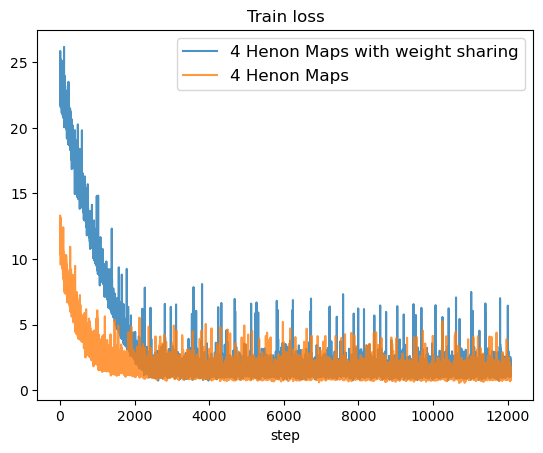

In [13]:
plt.plot(train_loss_tie, alpha=0.8, label="4 Henon Maps with weight sharing")
plt.plot(train_loss, alpha=0.8, label="4 Henon Maps")
plt.xlabel('step')
plt.title("Train loss")
plt.legend(fontsize=12)
plt.show()

### Models
- HenonNet symplectic $T_W$: Sec.1
    - Model predictions $\hat{x}_o, \hat{v}_o = T_W(x, v)$
    - Target $x_o = \sqrt{2J} \sin \omega, v_o = \sqrt{2J} \cos \omega$ from Adrian's action-angle pair
    - Optimize $T_W$ to minimize MSE loss $\ell([\hat{x}_o; \hat{v}_o], [x_o, v_o])$
- HenonNetsupQ sympletic $T_W$ and predictor for target quantity $\xi_Q$: Sec.3
    - Model predictions $$\hat{x}_o, \hat{v}_o = T_W(x, v); \quad \widehat{J} = 0.5(\hat{x}_o^2 + \hat{v}_o^2); \quad \widehat{Q} = \xi_Q(\widehat{J})$$
    - Target $x_o, v_o, Q$
    - Loss $\ell([\hat{x}_o; \hat{v}_o], [x_o, v_o]) + \beta \ell(\widehat{Q}, Q)$

In [34]:
def plot_pred(x_pred, v_pred, Q, title, ax,
              xlabel=r"$\sqrt{J_z} \cos(\theta_z)$", ylabel=r"$\sqrt{J_z} \sin(\theta_z)$", swap=True):
    stat_Jth = binned_statistic_2d(x_pred,v_pred,Q,bins=np.linspace(-15, 15, 128))
    ax.pcolormesh(
        stat_Jth.x_edge,
        stat_Jth.y_edge,
        stat_Jth.statistic.T,
        vmin=0, vmax=0.4
    )
    for r in [2, 4, 6, 8, 10]:
        ax.add_patch(plt.Circle((0, 0), r, facecolor="none", edgecolor="tab:blue", lw=1.5))
    if swap:
        ax.set(xlabel=ylabel, ylabel=xlabel)
    else:
        ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.set_title(title)
    ax.axis('equal')

def load_data(file_path, data_path, swap=True, standardize=True):
    #obtain eval set prediction 
    save_file = pickle.load(open(file_path,"rb"))        
    x_pred = save_file['x_pred']
    v_pred = save_file['v_pred']
    mean_in, std_in =  save_file['input_mean_std']
    mean_out, std_out = save_file['output_mean_std']
    xv_pred = torch.concatenate((x_pred,v_pred), axis=-1)
    if standardize == False:
        xv_pred = from_standard(xv_pred, mean_out, std_out)
    #xv_pred = from_standard(torch.concatenate((x_pred,v_pred), axis=-1), mean, std)
    data_dict =  pickle.load(open(data_path, "rb"))
    train_indices, val_indices, test_indices = data_dict['splits']
    Q = data_dict['Q'][val_indices]
    if swap:
        X_o = data_dict['V_o'][val_indices]
        V_o = data_dict['X_o'][val_indices]
    else:
        X_o = data_dict['X_o'][val_indices]
        V_o = data_dict['V_o'][val_indices]
    xv_out = torch.from_numpy(np.stack((X_o, V_o), axis=-1)).float()
    X = data_dict['X'][val_indices]
    V = data_dict['V'][val_indices]
    xv = torch.from_numpy(np.stack((X, V), axis=-1)).float()
    if standardize:
        xv = (xv - mean_in)/std_in 
        xv_out = (xv_out - mean_out)/std_out
    #eturn xv_pred, X_o, V_o, X, V, Q, save_file['train_loss']
    return xv_pred, xv_out, xv, Q, save_file['train_loss']

def load_data_supQ(file_path, data_path, swap=True):
    #obtain eval set prediction 
    save_file = pickle.load(open(file_path,"rb"))
    x_pred = save_file['x_pred']
    v_pred = save_file['v_pred']
    Q_pred = save_file['Q_pred']
    mean, std = save_file['data_mean_std']
    xv_pred = from_standard(np.concatenate((x_pred,v_pred), axis=-1), mean, std)
    data_dict =  pickle.load(open(data_path, "rb"))
    train_indices, val_indices, test_indices = data_dict['splits']
    Q = data_dict['Q'][val_indices]
    if swap:
        X_o = data_dict['V_o'][val_indices]
        V_o = data_dict['X_o'][val_indices]
    else:
        X_o = data_dict['X_o'][val_indices]
        V_o = data_dict['V_o'][val_indices]
    X = data_dict['X'][val_indices]
    V = data_dict['V'][val_indices]
    return xv_pred, Q_pred, X_o, V_o, X, V, Q, save_file['train_loss']

In [43]:
def plot_input_output(XV, XV_out, pred_XV_out, untrain_XV_out):
    assert XV.shape == XV_out.shape == pred_XV_out.shape
    fig, axs = plt.subplots(figsize=(12, 6), ncols=2)
    for i in range(2):
        axs[i].scatter(XV[:,i], XV_out[:,i], label='target', color='tab:blue', alpha=0.7)
        axs[i].scatter(XV[:,i], pred_XV_out[:,i], label='prediction', color='tab:orange', alpha=0.7)
        axs[i].scatter(XV[:,i], untrain_XV_out[:,i], label='prediction (untrain)', color='tab:gray', alpha=0.7)

    axs[0].set_title('position', fontsize=15)
    axs[1].set_title('velocity', fontsize=15)
    for ax in axs:
        ax.axline((0, 0), slope=1, color='gray', ls='--') #reference y=x
        ax.set_xlabel('input', fontsize=15)
        ax.set_ylabel('target', fontsize=15)
        ax.legend(fontsize=15, loc='upper left')
    fig.tight_layout()
    plt.show()

#### Results of untrain HenonNet

In [6]:
hid_dim = 2
num_layers = 1

model = HenonNet(input_dim=1, hid_dim=hid_dim, num_layers=num_layers)
model.eval()

HenonNet(
  (hlayers): Sequential(
    (0): HenonLayer()
  )
)

In [46]:
file_path = f"results/_layer={num_layers}_hid={hid_dim}_lr=0.01_tie=False_ep=30/save_file.pkl"
data_path = "data_1D_dim=2.pkl"
#xv_pred, X_o, V_o, X, V, Q, train_loss = load_data(file_path, data_path)
xv_pred, xv_out, xv, Q, train_loss = load_data(file_path, data_path)

In [47]:
untrain_pred = model(xv[:,:1], xv[:, 1:])
untrain_xv_pred = torch.concatenate(untrain_pred,axis=-1).detach()

In [48]:
untrain_pred[1].std(), X.std()

(tensor(5.5447, grad_fn=<StdBackward0>), 1.0688604045946557)

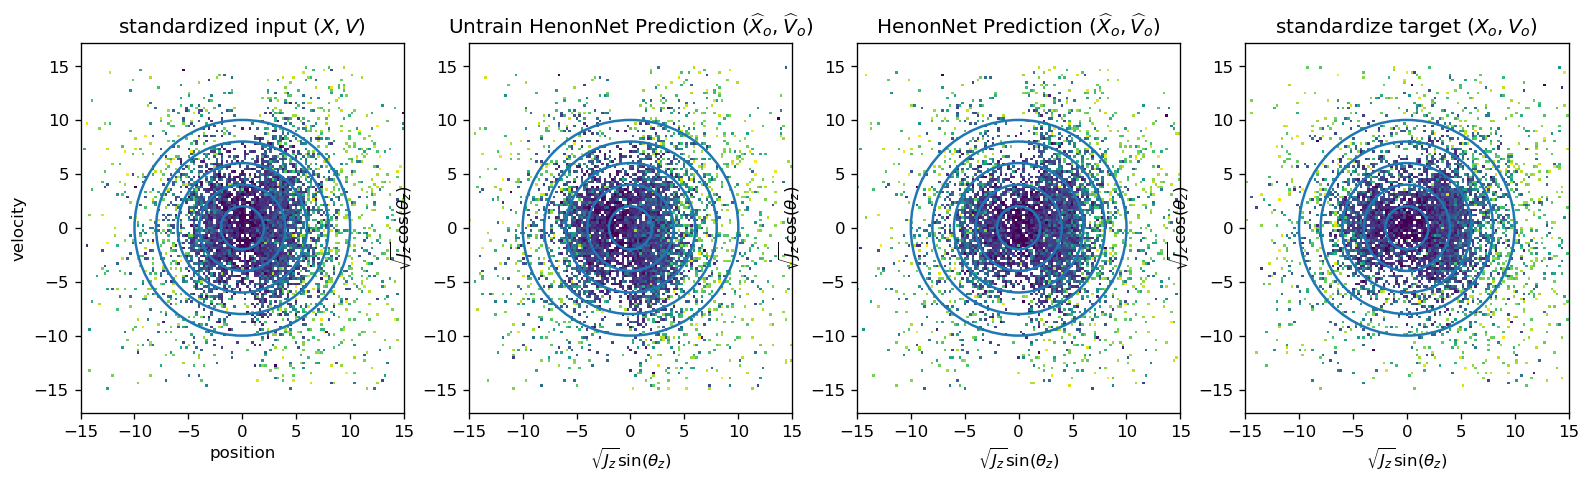

In [49]:
fig, axs = plt.subplots(figsize=(16, 4),ncols=4,dpi=120)
plot_pred(xv[:,0], xv[:,1], Q, title=r'standardized input $(X,V)$', 
          ax=axs[0], xlabel='position', ylabel='velocity', swap=False)

plot_pred(untrain_xv_pred[:,0], untrain_xv_pred[:,1], 
          Q, title=r'Untrain HenonNet Prediction $(\widehat{X}_o, \widehat{V}_o)$', ax=axs[1])
plot_pred(xv_pred[:,0], xv_pred[:,1], 
          Q, title=r'HenonNet Prediction $(\widehat{X}_o, \widehat{V}_o)$', ax=axs[2])
plot_pred(xv_out[:,0], xv_out[:,1], Q, title=r'standardize target $(X_o, V_o)$', 
          swap=True, ax=axs[3])

#### Results of using HenonNet (sec.1)

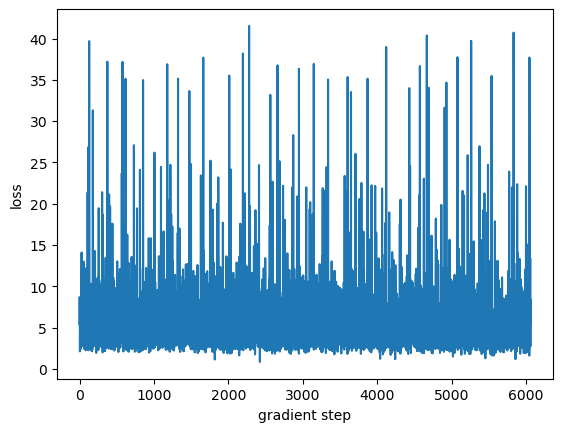

In [50]:
plt.plot(train_loss)
plt.xlabel('gradient step')
plt.ylabel('loss')
plt.show()

In [30]:
F.mse_loss(xv, xv_out) ##baseline=identity map without any training

tensor(5.6428)

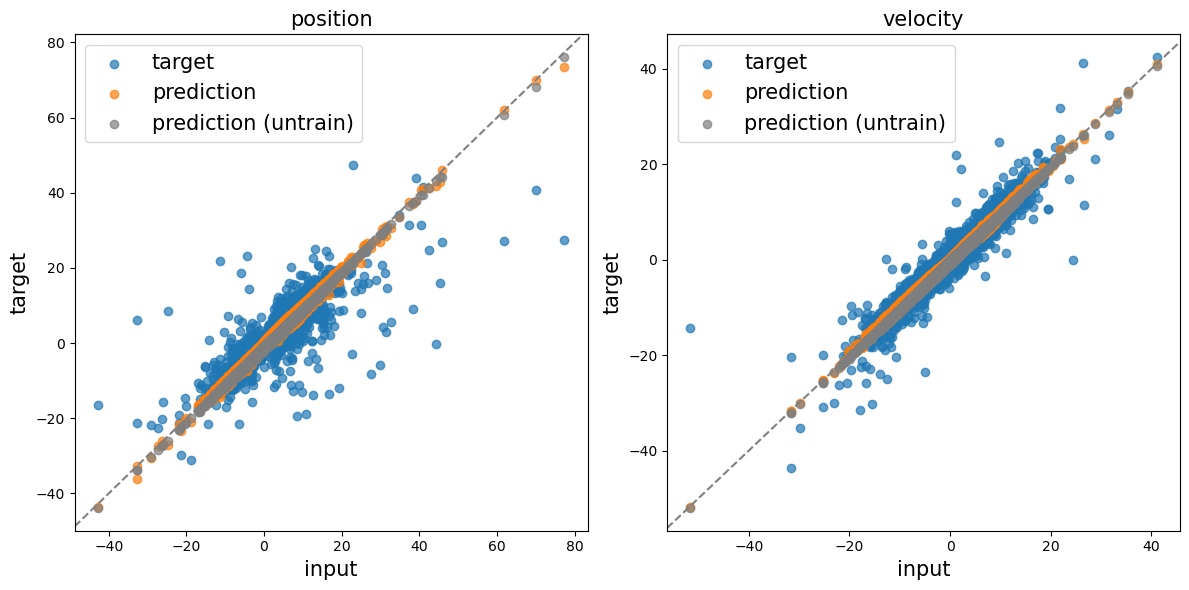

In [44]:
plot_input_output(xv, xv_out, xv_pred, untrain_xv_pred)

#### Results for HenonNetsupQ (Sec.3)

In [154]:

file_path = "results_supQ/_layer=4_hid=32_lr=0.01_tie=False_ep=30_bs=1024/save_file.pkl"
data_path = "data_1D_dim=2.pkl"
xv_pred, Q_pred, X_o, V_o, X, V, Q, train_loss = load_data_supQ(file_path, data_path)